#Setting up environment

In [1]:
import os
import torch
import numpy as np
from torchvision.transforms.functional import to_tensor, to_pil_image
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Change this to the folder containing your model. Place all test images inside as well.
os.chdir('//content//gdrive//My Drive//BackgroundMattingV2-master')

#Load model

In [4]:
from model import MattingRefine

device = torch.device('cuda')
precision = torch.float32

model = MattingRefine(backbone='mobilenetv2',
                      backbone_scale=0.25,
                      refine_mode='sampling',
                      refine_sample_pixels=80_000)

model.load_state_dict(torch.load('pytorch_mobilenetv2.pth'))
model = model.eval().to(precision).to(device)

# Run model

In [10]:
# Load source & background images, and convert them to Pytorch tensors.
src = Image.open('img.png')
bgr = Image.open('bgr.png')
src = to_tensor(src).cuda().unsqueeze(0)
bgr = to_tensor(bgr).cuda().unsqueeze(0)

# Run model on the inputs.
with torch.no_grad():
    pha, fgr = model(src, bgr)[:2]

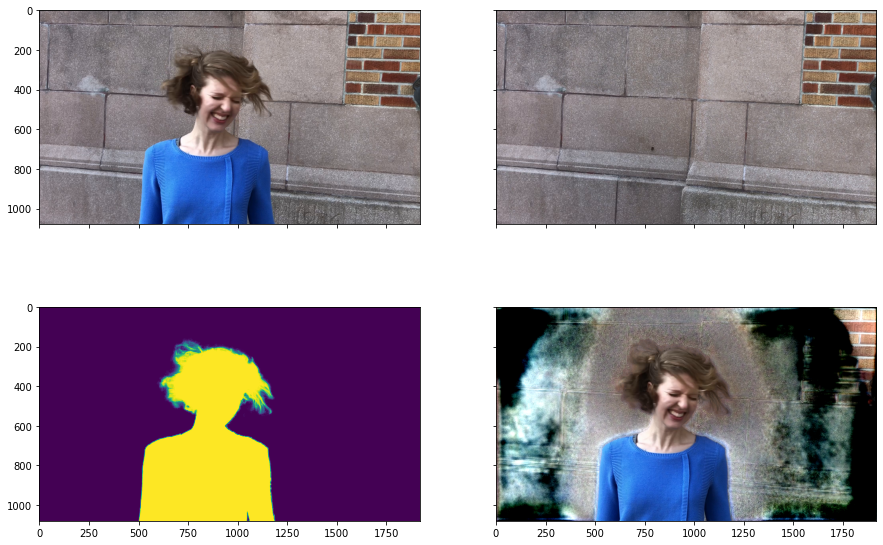

In [20]:
fig, ax = plt.subplots(2,2, figsize = (15,10), sharex = True, sharey = True)
ax[0,0].imshow(np.array(to_pil_image(src[0])))
ax[0,1].imshow(np.array(to_pil_image(bgr[0])))
ax[1,0].imshow(np.array(to_pil_image(pha[0])))
ax[1,1].imshow(np.array(to_pil_image(fgr[0])))

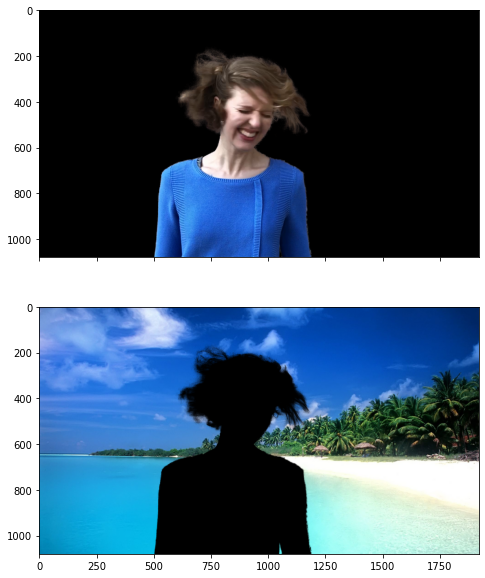

In [22]:
fig, ax = plt.subplots(2, figsize = (15,10), sharex = True, sharey = True)
ax[0].imshow(fg)
ax[1].imshow(bg)

# Background replacement

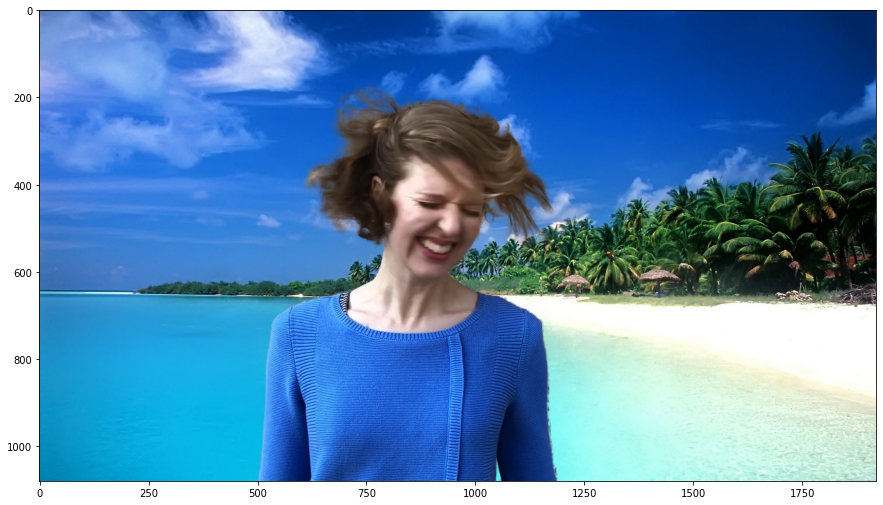

In [18]:
# Load replacement background image.
new_bgr = np.array(Image.open('beach.jpg'))

# Convert model outputs to numpy arrays
pha_arr = np.array(to_pil_image((pha)[0]))
fgr_arr = np.array(to_pil_image((fgr)[0]))

# Form the inverse alpha mask
inv_pha = 255 - pha_arr

# Alpha-mask the foreground.
fg = fgr_arr.astype('float32')
fg[:,:,0] = fg[:,:,0] * pha_arr / 255
fg[:,:,1] = fg[:,:,1] * pha_arr / 255
fg[:,:,2] = fg[:,:,2] * pha_arr / 255
fg = fg.astype('uint8')

# Inverse-alpha-mask the new background.
bg = new_bgr.astype('float32')
bg[:,:,0] = bg[:,:,0] * inv_pha / 255
bg[:,:,1] = bg[:,:,1] * inv_pha / 255
bg[:,:,2] = bg[:,:,2] * inv_pha / 255
bg = bg.astype('uint8')

# Add both to form the composite image
composite = bg + fg

plt.figure(figsize = (15,10))
plt.imshow(composite)